This notebook is a copy of original notebook from google colab!

# Fire Segmentation
Model training notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install MMSegmentation
 PyTorch 1.12 and CUDA 11.2 are used.

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▌                 | 834.1 MB 1.2 MB/s eta 0:13:42tcmalloc: large alloc 1147494400 bytes == 0x392f4000 @  0x7f3967fe2615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████▍             | 1055.7 MB 1.2 MB/s eta 0:10:37tcmalloc: large alloc 1434370048 bytes == 0x7d94a000 @  0x7f3967fe2615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |███████████████████████▎        | 

In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 12906, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 12906 (delta 41), reused 73 (delta 33), pack-reused 12791
Receiving objects: 100% (12906/12906), 15.16 MiB | 43.99 MiB/s, done.
Resolving deltas: 100% (9321/9321), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 648 kB 4.8 MB/s 
  Running setup.py develop for mmsegmentation


In [ ]:
# check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.29.1


## Training of a semantic segmentation model

To train on a customized dataset, the following steps are carried out.
1. add a new dataset class 
2. create a config file accordingly
3. perform training and evaluation 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. Fortunately the dataset that is used is already in correct format. 

There are 3 classes:
- 0 backbround
- 1 smoke
- 2 fire

In [ ]:
# download and unzip
!wget http://merlin.fit.vutbr.cz/fire/dataset-fire-labelme-2019-06-14-cropped.tar.bz2 -O fire.tar.bz2
!mkdir dataset_fire
!tar xf fire.tar.bz2 -C dataset_fire

--2022-12-31 17:22:33--  http://merlin.fit.vutbr.cz/fire/dataset-fire-labelme-2019-06-14-cropped.tar.bz2
Resolving merlin.fit.vutbr.cz (merlin.fit.vutbr.cz)... 147.229.176.19, 2001:67c:1220:8b0::93e5:b013
Connecting to merlin.fit.vutbr.cz (merlin.fit.vutbr.cz)|147.229.176.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481046108 (459M) [application/x-bzip2]
Saving to: ‘fire.tar.bz2’

fire.tar.bz2        100%[===================>] 458.76M  12.2MB/s    in 39s     

2022-12-31 17:23:12 (11.9 MB/s) - ‘fire.tar.bz2’ saved [481046108/481046108]



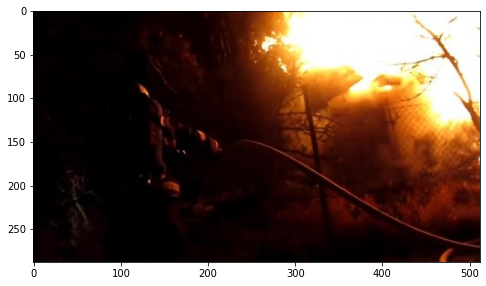

In [ ]:
# take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('dataset_fire/dataset-fire-labelme-cropped-Images/2015-01-01_pozar_chaty__Brno-R-_gtzPSHZE_mkv/00003500.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Since there is no palette included in the semantic segmentation map, we need to add one for better visualization.

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'dataset_fire'
img_dir = 'dataset-fire-labelme-cropped-Images'
ann_dir = 'dataset-fire-labelme-cropped-Mask'
# define class and plaette for better visualization
classes = ['background', 'fire', 'smoke']
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125]]
for file_path in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.png',recursive=True):
  seg_img = Image.open(osp.join(data_root, ann_dir, file_path)).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file_path))

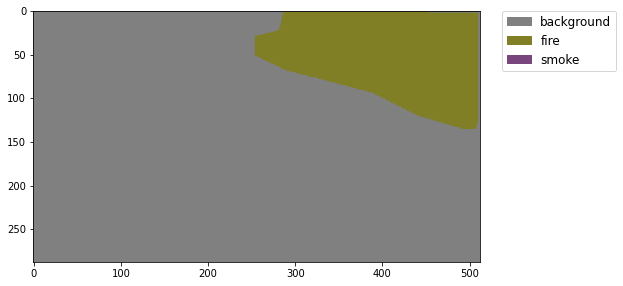

In [ ]:
# take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('dataset_fire/dataset-fire-labelme-cropped-Mask/2015-01-01_pozar_chaty__Brno-R-_gtzPSHZE_mkv/00003500.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')
plt.show()

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

# register dataset
@DATASETS.register_module()
class FireDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

### Create a config file
Config for is training modified, to accelerate the process, we finetune the model from trained weights.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=150,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,

Since the given config is used to train DeeplabV3+ on the ADE20k dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'FireDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2 

cfg.img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'test.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/Colab Notebooks/NI-MVI/logs/'

cfg.runner.max_iters = 12000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_in

### Train and Evaluation

In [19]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# build the dataset
datasets = [build_dataset(cfg.data.train)]

# build the detector
model = build_segmentor(cfg.model)
# add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-12-31 17:24:05,304 - mmseg - INFO - Loaded 4375 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2022-12-31 17:24:06,937 - mmseg - INFO - Loaded 1250 images
2022-12-31 17:24:06,939 - mmseg - INFO - load checkpoint from local path: checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth
2022-12-31 17:24:07,081 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([150, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shap

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.2 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:25:07,967 - mmseg - INFO - per class results:
2022-12-31 17:25:07,969 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.47 |  99.9 |
|    fire    | 14.93 | 15.32 |
|   smoke    |  0.0  |  0.0  |
+------------+-------+-------+
2022-12-31 17:25:07,970 - mmseg - INFO - Summary:
2022-12-31 17:25:07,971 - mmseg - INFO - 
+------+------+------+
| aAcc | mIoU | mAcc |
+------+------+------+
| 95.5 | 36.8 | 38.4 |
+------+------+------+
2022-12-31 17:25:07,973 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9550, mIoU: 0.3680, mAcc: 0.3840, IoU.background: 0.9547, IoU.fire: 0.1493, IoU.smoke: 0.0000, Acc.background: 0.9990, Acc.fire: 0.1532, Acc.smoke: 0.0000
2022-12-31 17:25:08,892 - mmseg - INFO - Iter [210/12000]	lr: 9.845e-03, eta: 0:57:22, time: 3.550, data_time: 3.462, memory: 3898, decode.loss_ce: 0.2045, decode.acc_seg: 91.9519, aux.loss_ce: 0.0745, aux.acc_seg: 92.5395, loss: 0.2790
2022-12-31 17:25

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.6 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:26:10,140 - mmseg - INFO - per class results:
2022-12-31 17:26:10,142 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.52 | 97.26 |
|    fire    | 47.91 |  81.8 |
|   smoke    |  0.0  |  0.0  |
+------------+-------+-------+
2022-12-31 17:26:10,143 - mmseg - INFO - Summary:
2022-12-31 17:26:10,145 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.55 | 47.81 | 59.69 |
+-------+-------+-------+
2022-12-31 17:26:10,146 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9555, mIoU: 0.4781, mAcc: 0.5969, IoU.background: 0.9552, IoU.fire: 0.4791, IoU.smoke: 0.0000, Acc.background: 0.9726, Acc.fire: 0.8180, Acc.smoke: 0.0000
2022-12-31 17:26:11,057 - mmseg - INFO - Iter [410/12000]	lr: 9.696e-03, eta: 0:58:10, time: 3.512, data_time: 3.425, memory: 3898, decode.loss_ce: 0.0908, decode.acc_seg: 96.1012, aux.loss_ce: 0.0397, aux.acc_seg: 96.0368, loss: 0.1304
2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.6 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:27:10,349 - mmseg - INFO - per class results:
2022-12-31 17:27:10,351 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.48 | 99.43 |
|    fire    | 43.94 | 50.11 |
|   smoke    |  9.87 | 10.35 |
+------------+-------+-------+
2022-12-31 17:27:10,353 - mmseg - INFO - Summary:
2022-12-31 17:27:10,354 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 96.51 | 50.1 | 53.3 |
+-------+------+------+
2022-12-31 17:27:10,355 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9651, mIoU: 0.5010, mAcc: 0.5330, IoU.background: 0.9648, IoU.fire: 0.4394, IoU.smoke: 0.0987, Acc.background: 0.9943, Acc.fire: 0.5011, Acc.smoke: 0.1035
2022-12-31 17:27:11,268 - mmseg - INFO - Iter [610/12000]	lr: 9.547e-03, eta: 0:57:09, time: 3.508, data_time: 3.421, memory: 3898, decode.loss_ce: 0.1332, decode.acc_seg: 94.6855, aux.loss_ce: 0.0468, aux.acc_seg: 94.9043, loss: 0.1800
2022-12-31 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:28:10,260 - mmseg - INFO - per class results:
2022-12-31 17:28:10,262 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.77 | 99.61 |
|    fire    | 53.31 | 56.58 |
|   smoke    |  1.17 |  1.33 |
+------------+-------+-------+
2022-12-31 17:28:10,263 - mmseg - INFO - Summary:
2022-12-31 17:28:10,265 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 96.82 | 50.42 | 52.5 |
+-------+-------+------+
2022-12-31 17:28:10,266 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9682, mIoU: 0.5042, mAcc: 0.5250, IoU.background: 0.9677, IoU.fire: 0.5331, IoU.smoke: 0.0117, Acc.background: 0.9961, Acc.fire: 0.5658, Acc.smoke: 0.0133
2022-12-31 17:28:11,189 - mmseg - INFO - Iter [810/12000]	lr: 9.397e-03, eta: 0:56:05, time: 3.525, data_time: 3.437, memory: 3898, decode.loss_ce: 0.1317, decode.acc_seg: 94.8321, aux.loss_ce: 0.0558, aux.acc_seg: 94.4804, loss: 0.1875
2022-1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:29:08,521 - mmseg - INFO - per class results:
2022-12-31 17:29:08,523 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 95.78 | 98.47 |
|    fire    | 35.98 | 41.78 |
|   smoke    | 34.07 | 59.61 |
+------------+-------+-------+
2022-12-31 17:29:08,524 - mmseg - INFO - Summary:
2022-12-31 17:29:08,525 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 95.85 | 55.28 | 66.62 |
+-------+-------+-------+
2022-12-31 17:29:08,526 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9585, mIoU: 0.5528, mAcc: 0.6662, IoU.background: 0.9578, IoU.fire: 0.3598, IoU.smoke: 0.3407, Acc.background: 0.9847, Acc.fire: 0.4178, Acc.smoke: 0.5961
2022-12-31 17:29:09,445 - mmseg - INFO - Iter [1010/12000]	lr: 9.248e-03, eta: 0:54:44, time: 3.521, data_time: 3.433, memory: 3898, decode.loss_ce: 0.1063, decode.acc_seg: 95.6598, aux.loss_ce: 0.0420, aux.acc_seg: 95.8149, loss: 0.1483


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.1 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:30:09,294 - mmseg - INFO - per class results:
2022-12-31 17:30:09,296 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.42 | 97.75 |
|    fire    | 56.02 |  84.3 |
|   smoke    | 23.65 | 29.76 |
+------------+-------+-------+
2022-12-31 17:30:09,297 - mmseg - INFO - Summary:
2022-12-31 17:30:09,298 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 96.45 | 58.7 | 70.6 |
+-------+------+------+
2022-12-31 17:30:09,300 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9645, mIoU: 0.5870, mAcc: 0.7060, IoU.background: 0.9642, IoU.fire: 0.5602, IoU.smoke: 0.2365, Acc.background: 0.9775, Acc.fire: 0.8430, Acc.smoke: 0.2976
2022-12-31 17:30:10,221 - mmseg - INFO - Iter [1210/12000]	lr: 9.098e-03, eta: 0:53:53, time: 3.554, data_time: 3.467, memory: 3898, decode.loss_ce: 0.1238, decode.acc_seg: 94.6672, aux.loss_ce: 0.0483, aux.acc_seg: 95.2920, loss: 0.1722
2022-12-31

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:31:08,098 - mmseg - INFO - per class results:
2022-12-31 17:31:08,099 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.02 | 98.88 |
|    fire    |  63.1 | 81.36 |
|   smoke    |  0.0  |  0.0  |
+------------+-------+-------+
2022-12-31 17:31:08,101 - mmseg - INFO - Summary:
2022-12-31 17:31:08,102 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.07 | 53.37 | 60.08 |
+-------+-------+-------+
2022-12-31 17:31:08,104 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9707, mIoU: 0.5337, mAcc: 0.6008, IoU.background: 0.9702, IoU.fire: 0.6310, IoU.smoke: 0.0000, Acc.background: 0.9888, Acc.fire: 0.8136, Acc.smoke: 0.0000
2022-12-31 17:31:09,030 - mmseg - INFO - Iter [1410/12000]	lr: 8.947e-03, eta: 0:52:45, time: 3.521, data_time: 3.433, memory: 3898, decode.loss_ce: 0.1144, decode.acc_seg: 95.1713, aux.loss_ce: 0.0503, aux.acc_seg: 95.2296, loss: 0.1647


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.3 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:32:06,632 - mmseg - INFO - per class results:
2022-12-31 17:32:06,634 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.15 | 96.84 |
|    fire    |  57.1 | 89.45 |
|   smoke    | 38.01 | 68.53 |
+------------+-------+-------+
2022-12-31 17:32:06,635 - mmseg - INFO - Summary:
2022-12-31 17:32:06,636 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.22 | 63.75 | 84.94 |
+-------+-------+-------+
2022-12-31 17:32:06,638 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9622, mIoU: 0.6375, mAcc: 0.8494, IoU.background: 0.9615, IoU.fire: 0.5710, IoU.smoke: 0.3801, Acc.background: 0.9684, Acc.fire: 0.8945, Acc.smoke: 0.6853
2022-12-31 17:32:07,545 - mmseg - INFO - Iter [1610/12000]	lr: 8.797e-03, eta: 0:51:37, time: 3.541, data_time: 3.454, memory: 3898, decode.loss_ce: 0.0821, decode.acc_seg: 96.7003, aux.loss_ce: 0.0349, aux.acc_seg: 96.7226, loss: 0.1170


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:33:06,903 - mmseg - INFO - per class results:
2022-12-31 17:33:06,904 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.31 | 99.48 |
|    fire    | 57.71 | 61.27 |
|   smoke    | 34.77 | 43.32 |
+------------+-------+-------+
2022-12-31 17:33:06,905 - mmseg - INFO - Summary:
2022-12-31 17:33:06,906 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.36 | 63.26 | 68.02 |
+-------+-------+-------+
2022-12-31 17:33:06,907 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9736, mIoU: 0.6326, mAcc: 0.6802, IoU.background: 0.9731, IoU.fire: 0.5771, IoU.smoke: 0.3477, Acc.background: 0.9948, Acc.fire: 0.6127, Acc.smoke: 0.4332
2022-12-31 17:33:07,818 - mmseg - INFO - Iter [1810/12000]	lr: 8.646e-03, eta: 0:50:41, time: 3.517, data_time: 3.430, memory: 3898, decode.loss_ce: 0.0989, decode.acc_seg: 96.4002, aux.loss_ce: 0.0394, aux.acc_seg: 96.7881, loss: 0.1383


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:34:06,640 - mmseg - INFO - per class results:
2022-12-31 17:34:06,641 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.41 |  98.5 |
|    fire    | 67.35 | 84.86 |
|   smoke    | 38.25 | 53.77 |
+------------+-------+-------+
2022-12-31 17:34:06,642 - mmseg - INFO - Summary:
2022-12-31 17:34:06,644 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.46 | 67.67 | 79.04 |
+-------+-------+-------+
2022-12-31 17:34:06,645 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9746, mIoU: 0.6767, mAcc: 0.7904, IoU.background: 0.9741, IoU.fire: 0.6735, IoU.smoke: 0.3825, Acc.background: 0.9850, Acc.fire: 0.8486, Acc.smoke: 0.5377
2022-12-31 17:34:07,560 - mmseg - INFO - Iter [2010/12000]	lr: 8.495e-03, eta: 0:49:41, time: 3.530, data_time: 3.443, memory: 3898, decode.loss_ce: 0.1092, decode.acc_seg: 96.1411, aux.loss_ce: 0.0362, aux.acc_seg: 96.4653, loss: 0.1454


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:35:02,683 - mmseg - INFO - per class results:
2022-12-31 17:35:02,685 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.23 | 99.06 |
|    fire    | 60.53 | 71.07 |
|   smoke    | 31.07 | 37.97 |
+------------+-------+-------+
2022-12-31 17:35:02,686 - mmseg - INFO - Summary:
2022-12-31 17:35:02,687 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.28 | 62.94 | 69.37 |
+-------+-------+-------+
2022-12-31 17:35:02,688 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9728, mIoU: 0.6294, mAcc: 0.6937, IoU.background: 0.9723, IoU.fire: 0.6053, IoU.smoke: 0.3107, Acc.background: 0.9906, Acc.fire: 0.7107, Acc.smoke: 0.3797
2022-12-31 17:35:03,606 - mmseg - INFO - Iter [2210/12000]	lr: 8.344e-03, eta: 0:48:26, time: 3.520, data_time: 3.433, memory: 3898, decode.loss_ce: 0.0919, decode.acc_seg: 96.3769, aux.loss_ce: 0.0389, aux.acc_seg: 96.2970, loss: 0.1308


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:35:56,609 - mmseg - INFO - per class results:
2022-12-31 17:35:56,611 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.41 | 98.75 |
|    fire    | 65.98 | 84.69 |
|   smoke    |  29.8 | 33.49 |
+------------+-------+-------+
2022-12-31 17:35:56,612 - mmseg - INFO - Summary:
2022-12-31 17:35:56,615 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 97.46 | 64.4 | 72.31 |
+-------+------+-------+
2022-12-31 17:35:56,616 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9746, mIoU: 0.6440, mAcc: 0.7231, IoU.background: 0.9741, IoU.fire: 0.6598, IoU.smoke: 0.2980, Acc.background: 0.9875, Acc.fire: 0.8469, Acc.smoke: 0.3349
2022-12-31 17:35:57,532 - mmseg - INFO - Iter [2410/12000]	lr: 8.192e-03, eta: 0:47:05, time: 3.525, data_time: 3.438, memory: 3898, decode.loss_ce: 0.0809, decode.acc_seg: 97.1113, aux.loss_ce: 0.0317, aux.acc_seg: 97.0996, loss: 0.1126
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.1 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:36:50,848 - mmseg - INFO - per class results:
2022-12-31 17:36:50,850 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.84 | 97.61 |
|    fire    | 61.02 | 89.62 |
|   smoke    | 39.93 | 59.84 |
+------------+-------+-------+
2022-12-31 17:36:50,851 - mmseg - INFO - Summary:
2022-12-31 17:36:50,852 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.87 | 65.93 | 82.36 |
+-------+-------+-------+
2022-12-31 17:36:50,855 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9687, mIoU: 0.6593, mAcc: 0.8236, IoU.background: 0.9684, IoU.fire: 0.6102, IoU.smoke: 0.3993, Acc.background: 0.9761, Acc.fire: 0.8962, Acc.smoke: 0.5984
2022-12-31 17:36:51,770 - mmseg - INFO - Iter [2610/12000]	lr: 8.040e-03, eta: 0:45:49, time: 3.556, data_time: 3.469, memory: 3898, decode.loss_ce: 0.1364, decode.acc_seg: 93.0973, aux.loss_ce: 0.0591, aux.acc_seg: 93.0435, loss: 0.1955


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:37:47,086 - mmseg - INFO - per class results:
2022-12-31 17:37:47,088 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.18 |  97.5 |
|    fire    | 51.34 | 78.99 |
|   smoke    | 37.98 | 50.46 |
+------------+-------+-------+
2022-12-31 17:37:47,089 - mmseg - INFO - Summary:
2022-12-31 17:37:47,090 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.25 | 61.83 | 75.65 |
+-------+-------+-------+
2022-12-31 17:37:47,091 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9625, mIoU: 0.6183, mAcc: 0.7565, IoU.background: 0.9618, IoU.fire: 0.5134, IoU.smoke: 0.3798, Acc.background: 0.9750, Acc.fire: 0.7899, Acc.smoke: 0.5046
2022-12-31 17:37:48,007 - mmseg - INFO - Iter [2810/12000]	lr: 7.888e-03, eta: 0:44:43, time: 3.527, data_time: 3.440, memory: 3898, decode.loss_ce: 0.0921, decode.acc_seg: 95.2367, aux.loss_ce: 0.0424, aux.acc_seg: 94.6588, loss: 0.1344


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.3 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:38:41,268 - mmseg - INFO - per class results:
2022-12-31 17:38:41,270 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.67 | 98.63 |
|    fire    | 69.45 | 85.07 |
|   smoke    | 43.09 | 62.33 |
+------------+-------+-------+
2022-12-31 17:38:41,271 - mmseg - INFO - Summary:
2022-12-31 17:38:41,273 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.69 | 70.07 | 82.01 |
+-------+-------+-------+
2022-12-31 17:38:41,275 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9769, mIoU: 0.7007, mAcc: 0.8201, IoU.background: 0.9767, IoU.fire: 0.6945, IoU.smoke: 0.4309, Acc.background: 0.9863, Acc.fire: 0.8507, Acc.smoke: 0.6233
2022-12-31 17:38:42,191 - mmseg - INFO - Iter [3010/12000]	lr: 7.735e-03, eta: 0:43:32, time: 3.540, data_time: 3.453, memory: 3898, decode.loss_ce: 0.1096, decode.acc_seg: 96.1754, aux.loss_ce: 0.0505, aux.acc_seg: 96.0223, loss: 0.1601


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.3 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:39:35,335 - mmseg - INFO - per class results:
2022-12-31 17:39:35,336 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.52 |  98.4 |
|    fire    | 70.74 | 84.22 |
|   smoke    | 41.19 | 71.79 |
+------------+-------+-------+
2022-12-31 17:39:35,337 - mmseg - INFO - Summary:
2022-12-31 17:39:35,338 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 97.55 | 69.82 | 84.8 |
+-------+-------+------+
2022-12-31 17:39:35,339 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9755, mIoU: 0.6982, mAcc: 0.8480, IoU.background: 0.9752, IoU.fire: 0.7074, IoU.smoke: 0.4119, Acc.background: 0.9840, Acc.fire: 0.8422, Acc.smoke: 0.7179
2022-12-31 17:39:36,250 - mmseg - INFO - Iter [3210/12000]	lr: 7.582e-03, eta: 0:42:22, time: 3.535, data_time: 3.449, memory: 3898, decode.loss_ce: 0.0960, decode.acc_seg: 95.8324, aux.loss_ce: 0.0419, aux.acc_seg: 95.3482, loss: 0.1379
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:40:31,420 - mmseg - INFO - per class results:
2022-12-31 17:40:31,421 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  97.6 | 99.02 |
|    fire    | 70.07 | 87.07 |
|   smoke    | 16.25 | 17.13 |
+------------+-------+-------+
2022-12-31 17:40:31,422 - mmseg - INFO - Summary:
2022-12-31 17:40:31,424 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.62 | 61.31 | 67.74 |
+-------+-------+-------+
2022-12-31 17:40:31,425 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9762, mIoU: 0.6131, mAcc: 0.6774, IoU.background: 0.9760, IoU.fire: 0.7007, IoU.smoke: 0.1625, Acc.background: 0.9902, Acc.fire: 0.8707, Acc.smoke: 0.1713
2022-12-31 17:40:32,336 - mmseg - INFO - Iter [3410/12000]	lr: 7.428e-03, eta: 0:41:20, time: 3.514, data_time: 3.428, memory: 3898, decode.loss_ce: 0.0599, decode.acc_seg: 97.7784, aux.loss_ce: 0.0266, aux.acc_seg: 97.6008, loss: 0.0865


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.1 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:41:25,672 - mmseg - INFO - per class results:
2022-12-31 17:41:25,674 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.28 | 98.32 |
|    fire    | 69.14 | 79.68 |
|   smoke    | 37.58 | 72.94 |
+------------+-------+-------+
2022-12-31 17:41:25,675 - mmseg - INFO - Summary:
2022-12-31 17:41:25,676 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 97.31 | 68.0 | 83.65 |
+-------+------+-------+
2022-12-31 17:41:25,677 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9731, mIoU: 0.6800, mAcc: 0.8365, IoU.background: 0.9728, IoU.fire: 0.6914, IoU.smoke: 0.3758, Acc.background: 0.9832, Acc.fire: 0.7968, Acc.smoke: 0.7294
2022-12-31 17:41:26,601 - mmseg - INFO - Iter [3610/12000]	lr: 7.275e-03, eta: 0:40:14, time: 3.555, data_time: 3.467, memory: 3898, decode.loss_ce: 0.0819, decode.acc_seg: 96.4528, aux.loss_ce: 0.0361, aux.acc_seg: 95.9080, loss: 0.1180
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:42:19,597 - mmseg - INFO - per class results:
2022-12-31 17:42:19,599 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.29 | 99.01 |
|    fire    | 59.76 | 66.26 |
|   smoke    | 41.78 |  62.4 |
+------------+-------+-------+
2022-12-31 17:42:19,601 - mmseg - INFO - Summary:
2022-12-31 17:42:19,602 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.33 | 66.27 | 75.89 |
+-------+-------+-------+
2022-12-31 17:42:19,603 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9733, mIoU: 0.6627, mAcc: 0.7589, IoU.background: 0.9729, IoU.fire: 0.5976, IoU.smoke: 0.4178, Acc.background: 0.9901, Acc.fire: 0.6626, Acc.smoke: 0.6240
2022-12-31 17:42:20,519 - mmseg - INFO - Iter [3810/12000]	lr: 7.121e-03, eta: 0:39:09, time: 3.521, data_time: 3.434, memory: 3898, decode.loss_ce: 0.1113, decode.acc_seg: 94.4628, aux.loss_ce: 0.0510, aux.acc_seg: 93.9787, loss: 0.1623


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:43:15,657 - mmseg - INFO - per class results:
2022-12-31 17:43:15,658 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.91 | 98.94 |
|    fire    | 71.45 | 82.12 |
|   smoke    | 47.49 | 67.93 |
+------------+-------+-------+
2022-12-31 17:43:15,660 - mmseg - INFO - Summary:
2022-12-31 17:43:15,661 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 97.93 | 72.28 | 83.0 |
+-------+-------+------+
2022-12-31 17:43:15,663 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9793, mIoU: 0.7228, mAcc: 0.8300, IoU.background: 0.9791, IoU.fire: 0.7145, IoU.smoke: 0.4749, Acc.background: 0.9894, Acc.fire: 0.8212, Acc.smoke: 0.6793
2022-12-31 17:43:16,600 - mmseg - INFO - Iter [4010/12000]	lr: 6.966e-03, eta: 0:38:09, time: 3.522, data_time: 3.433, memory: 3898, decode.loss_ce: 0.0679, decode.acc_seg: 97.0545, aux.loss_ce: 0.0336, aux.acc_seg: 96.5866, loss: 0.1015
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.2 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:44:09,766 - mmseg - INFO - per class results:
2022-12-31 17:44:09,768 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.94 | 99.03 |
|    fire    | 73.46 | 86.38 |
|   smoke    | 37.81 | 48.03 |
+------------+-------+-------+
2022-12-31 17:44:09,769 - mmseg - INFO - Summary:
2022-12-31 17:44:09,770 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.96 | 69.74 | 77.81 |
+-------+-------+-------+
2022-12-31 17:44:09,773 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9796, mIoU: 0.6974, mAcc: 0.7781, IoU.background: 0.9794, IoU.fire: 0.7346, IoU.smoke: 0.3781, Acc.background: 0.9903, Acc.fire: 0.8638, Acc.smoke: 0.4803
2022-12-31 17:44:10,688 - mmseg - INFO - Iter [4210/12000]	lr: 6.811e-03, eta: 0:37:06, time: 3.544, data_time: 3.457, memory: 3898, decode.loss_ce: 0.0732, decode.acc_seg: 96.9276, aux.loss_ce: 0.0326, aux.acc_seg: 96.8361, loss: 0.1058


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:45:05,940 - mmseg - INFO - per class results:
2022-12-31 17:45:05,942 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.26 | 97.95 |
|    fire    | 65.22 | 93.86 |
|   smoke    | 40.94 | 53.86 |
+------------+-------+-------+
2022-12-31 17:45:05,943 - mmseg - INFO - Summary:
2022-12-31 17:45:05,944 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 97.28 | 67.8 | 81.89 |
+-------+------+-------+
2022-12-31 17:45:05,945 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9728, mIoU: 0.6780, mAcc: 0.8189, IoU.background: 0.9726, IoU.fire: 0.6522, IoU.smoke: 0.4094, Acc.background: 0.9795, Acc.fire: 0.9386, Acc.smoke: 0.5386
2022-12-31 17:45:06,859 - mmseg - INFO - Iter [4410/12000]	lr: 6.656e-03, eta: 0:36:07, time: 3.529, data_time: 3.442, memory: 3898, decode.loss_ce: 0.0528, decode.acc_seg: 97.7865, aux.loss_ce: 0.0206, aux.acc_seg: 98.2031, loss: 0.0734
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 35.7 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:46:00,555 - mmseg - INFO - per class results:
2022-12-31 17:46:00,556 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.26 | 98.78 |
|    fire    | 61.64 | 74.72 |
|   smoke    | 37.08 |  50.0 |
+------------+-------+-------+
2022-12-31 17:46:00,557 - mmseg - INFO - Summary:
2022-12-31 17:46:00,558 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 97.3 | 65.32 | 74.5 |
+------+-------+------+
2022-12-31 17:46:00,561 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9730, mIoU: 0.6532, mAcc: 0.7450, IoU.background: 0.9726, IoU.fire: 0.6164, IoU.smoke: 0.3708, Acc.background: 0.9878, Acc.fire: 0.7472, Acc.smoke: 0.5000
2022-12-31 17:46:01,491 - mmseg - INFO - Iter [4610/12000]	lr: 6.500e-03, eta: 0:35:06, time: 3.593, data_time: 3.505, memory: 3898, decode.loss_ce: 0.0564, decode.acc_seg: 97.3521, aux.loss_ce: 0.0297, aux.acc_seg: 96.1596, loss: 0.0861
2022-12-31

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:46:54,426 - mmseg - INFO - per class results:
2022-12-31 17:46:54,428 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.65 | 99.38 |
|    fire    | 65.79 | 71.22 |
|   smoke    |  37.9 | 47.79 |
+------------+-------+-------+
2022-12-31 17:46:54,430 - mmseg - INFO - Summary:
2022-12-31 17:46:54,431 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 97.7 | 67.11 | 72.8 |
+------+-------+------+
2022-12-31 17:46:54,432 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9770, mIoU: 0.6711, mAcc: 0.7280, IoU.background: 0.9765, IoU.fire: 0.6579, IoU.smoke: 0.3790, Acc.background: 0.9938, Acc.fire: 0.7122, Acc.smoke: 0.4779
2022-12-31 17:46:55,343 - mmseg - INFO - Iter [4810/12000]	lr: 6.344e-03, eta: 0:34:04, time: 3.518, data_time: 3.432, memory: 3898, decode.loss_ce: 0.0539, decode.acc_seg: 97.8691, aux.loss_ce: 0.0270, aux.acc_seg: 97.3610, loss: 0.0810
2022-12-31

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 35.4 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:47:51,551 - mmseg - INFO - per class results:
2022-12-31 17:47:51,553 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.55 | 98.25 |
|    fire    | 67.17 | 92.04 |
|   smoke    | 44.63 | 58.03 |
+------------+-------+-------+
2022-12-31 17:47:51,555 - mmseg - INFO - Summary:
2022-12-31 17:47:51,557 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.55 | 69.79 | 82.77 |
+-------+-------+-------+
2022-12-31 17:47:51,558 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9755, mIoU: 0.6979, mAcc: 0.8277, IoU.background: 0.9755, IoU.fire: 0.6717, IoU.smoke: 0.4463, Acc.background: 0.9825, Acc.fire: 0.9204, Acc.smoke: 0.5803
2022-12-31 17:47:52,485 - mmseg - INFO - Iter [5010/12000]	lr: 6.188e-03, eta: 0:33:08, time: 3.625, data_time: 3.536, memory: 3898, decode.loss_ce: 0.0521, decode.acc_seg: 97.2133, aux.loss_ce: 0.0193, aux.acc_seg: 97.4777, loss: 0.0714


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:48:45,795 - mmseg - INFO - per class results:
2022-12-31 17:48:45,797 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.74 | 99.19 |
|    fire    | 67.83 | 77.62 |
|   smoke    | 37.41 | 46.62 |
+------------+-------+-------+
2022-12-31 17:48:45,798 - mmseg - INFO - Summary:
2022-12-31 17:48:45,799 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.75 | 67.66 | 74.47 |
+-------+-------+-------+
2022-12-31 17:48:45,800 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9775, mIoU: 0.6766, mAcc: 0.7447, IoU.background: 0.9774, IoU.fire: 0.6783, IoU.smoke: 0.3741, Acc.background: 0.9919, Acc.fire: 0.7762, Acc.smoke: 0.4662
2022-12-31 17:48:46,718 - mmseg - INFO - Iter [5210/12000]	lr: 6.031e-03, eta: 0:32:07, time: 3.516, data_time: 3.429, memory: 3898, decode.loss_ce: 0.0756, decode.acc_seg: 96.5712, aux.loss_ce: 0.0384, aux.acc_seg: 95.7957, loss: 0.1141


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.7 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:49:39,501 - mmseg - INFO - per class results:
2022-12-31 17:49:39,503 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.64 | 98.36 |
|    fire    | 68.85 | 87.13 |
|   smoke    | 47.61 | 73.64 |
+------------+-------+-------+
2022-12-31 17:49:39,504 - mmseg - INFO - Summary:
2022-12-31 17:49:39,505 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.65 | 71.37 | 86.38 |
+-------+-------+-------+
2022-12-31 17:49:39,506 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9765, mIoU: 0.7137, mAcc: 0.8638, IoU.background: 0.9764, IoU.fire: 0.6885, IoU.smoke: 0.4761, Acc.background: 0.9836, Acc.fire: 0.8713, Acc.smoke: 0.7364
2022-12-31 17:49:40,420 - mmseg - INFO - Iter [5410/12000]	lr: 5.873e-03, eta: 0:31:07, time: 3.502, data_time: 3.415, memory: 3898, decode.loss_ce: 0.0755, decode.acc_seg: 96.2856, aux.loss_ce: 0.0361, aux.acc_seg: 95.9853, loss: 0.1117


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.7 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:50:35,522 - mmseg - INFO - per class results:
2022-12-31 17:50:35,524 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.82 | 98.56 |
|    fire    | 71.74 | 88.39 |
|   smoke    | 45.98 | 68.81 |
+------------+-------+-------+
2022-12-31 17:50:35,525 - mmseg - INFO - Summary:
2022-12-31 17:50:35,526 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.82 | 71.84 | 85.25 |
+-------+-------+-------+
2022-12-31 17:50:35,529 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9782, mIoU: 0.7184, mAcc: 0.8525, IoU.background: 0.9782, IoU.fire: 0.7174, IoU.smoke: 0.4598, Acc.background: 0.9856, Acc.fire: 0.8839, Acc.smoke: 0.6881
2022-12-31 17:50:36,441 - mmseg - INFO - Iter [5610/12000]	lr: 5.715e-03, eta: 0:30:09, time: 3.502, data_time: 3.416, memory: 3898, decode.loss_ce: 0.0623, decode.acc_seg: 97.4464, aux.loss_ce: 0.0286, aux.acc_seg: 97.2968, loss: 0.0909


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.7 task/s, elapsed: 34s, ETA:     0s

2022-12-31 17:51:29,169 - mmseg - INFO - per class results:
2022-12-31 17:51:29,170 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.43 | 99.23 |
|    fire    | 64.15 |  74.6 |
|   smoke    | 26.66 |  29.7 |
+------------+-------+-------+
2022-12-31 17:51:29,172 - mmseg - INFO - Summary:
2022-12-31 17:51:29,174 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.49 | 62.75 | 67.85 |
+-------+-------+-------+
2022-12-31 17:51:29,175 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9749, mIoU: 0.6275, mAcc: 0.6785, IoU.background: 0.9743, IoU.fire: 0.6415, IoU.smoke: 0.2666, Acc.background: 0.9923, Acc.fire: 0.7460, Acc.smoke: 0.2970
2022-12-31 17:51:30,089 - mmseg - INFO - Iter [5810/12000]	lr: 5.557e-03, eta: 0:29:09, time: 3.497, data_time: 3.410, memory: 3898, decode.loss_ce: 0.0913, decode.acc_seg: 95.3377, aux.loss_ce: 0.0399, aux.acc_seg: 94.8549, loss: 0.1312


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 35.2 task/s, elapsed: 35s, ETA:     0s

2022-12-31 17:52:24,289 - mmseg - INFO - per class results:
2022-12-31 17:52:24,290 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.68 | 98.45 |
|    fire    | 69.74 | 88.51 |
|   smoke    | 46.54 | 66.97 |
+------------+-------+-------+
2022-12-31 17:52:24,292 - mmseg - INFO - Summary:
2022-12-31 17:52:24,295 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.71 | 71.32 | 84.65 |
+-------+-------+-------+
2022-12-31 17:52:24,297 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9771, mIoU: 0.7132, mAcc: 0.8465, IoU.background: 0.9768, IoU.fire: 0.6974, IoU.smoke: 0.4654, Acc.background: 0.9845, Acc.fire: 0.8851, Acc.smoke: 0.6697
2022-12-31 17:52:27,390 - mmseg - INFO - Iter [6010/12000]	lr: 5.398e-03, eta: 0:28:14, time: 3.858, data_time: 3.770, memory: 3898, decode.loss_ce: 0.0827, decode.acc_seg: 96.0251, aux.loss_ce: 0.0357, aux.acc_seg: 95.7540, loss: 0.1184


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.9 task/s, elapsed: 33s, ETA:     0s

2022-12-31 17:53:19,133 - mmseg - INFO - per class results:
2022-12-31 17:53:19,134 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.79 |  99.1 |
|    fire    | 69.98 | 82.74 |
|   smoke    | 35.49 | 42.16 |
+------------+-------+-------+
2022-12-31 17:53:19,135 - mmseg - INFO - Summary:
2022-12-31 17:53:19,136 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.81 | 67.75 | 74.67 |
+-------+-------+-------+
2022-12-31 17:53:19,137 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9781, mIoU: 0.6775, mAcc: 0.7467, IoU.background: 0.9779, IoU.fire: 0.6998, IoU.smoke: 0.3549, Acc.background: 0.9910, Acc.fire: 0.8274, Acc.smoke: 0.4216
2022-12-31 17:53:20,034 - mmseg - INFO - Iter [6210/12000]	lr: 5.239e-03, eta: 0:27:13, time: 3.393, data_time: 3.308, memory: 3898, decode.loss_ce: 0.0394, decode.acc_seg: 97.7521, aux.loss_ce: 0.0190, aux.acc_seg: 97.3753, loss: 0.0584


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.1 task/s, elapsed: 32s, ETA:     0s

2022-12-31 17:54:10,472 - mmseg - INFO - per class results:
2022-12-31 17:54:10,474 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.61 | 99.19 |
|    fire    | 64.27 |  71.3 |
|   smoke    | 42.63 | 57.53 |
+------------+-------+-------+
2022-12-31 17:54:10,475 - mmseg - INFO - Summary:
2022-12-31 17:54:10,476 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.64 | 68.17 | 76.01 |
+-------+-------+-------+
2022-12-31 17:54:10,477 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9764, mIoU: 0.6817, mAcc: 0.7601, IoU.background: 0.9761, IoU.fire: 0.6427, IoU.smoke: 0.4263, Acc.background: 0.9919, Acc.fire: 0.7130, Acc.smoke: 0.5753
2022-12-31 17:54:11,383 - mmseg - INFO - Iter [6410/12000]	lr: 5.079e-03, eta: 0:26:13, time: 3.293, data_time: 3.207, memory: 3898, decode.loss_ce: 0.0851, decode.acc_seg: 96.3549, aux.loss_ce: 0.0383, aux.acc_seg: 96.2110, loss: 0.1235


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.1 task/s, elapsed: 32s, ETA:     0s

2022-12-31 17:55:04,214 - mmseg - INFO - per class results:
2022-12-31 17:55:04,216 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.83 | 99.23 |
|    fire    | 71.41 | 82.69 |
|   smoke    |  31.0 | 35.59 |
+------------+-------+-------+
2022-12-31 17:55:04,218 - mmseg - INFO - Summary:
2022-12-31 17:55:04,219 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 97.86 | 66.75 | 72.5 |
+-------+-------+------+
2022-12-31 17:55:04,221 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9786, mIoU: 0.6675, mAcc: 0.7250, IoU.background: 0.9783, IoU.fire: 0.7141, IoU.smoke: 0.3100, Acc.background: 0.9923, Acc.fire: 0.8269, Acc.smoke: 0.3559
2022-12-31 17:55:05,124 - mmseg - INFO - Iter [6610/12000]	lr: 4.918e-03, eta: 0:25:14, time: 3.290, data_time: 3.203, memory: 3898, decode.loss_ce: 0.0732, decode.acc_seg: 96.8285, aux.loss_ce: 0.0331, aux.acc_seg: 96.4410, loss: 0.1062
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.0 task/s, elapsed: 32s, ETA:     0s

2022-12-31 17:55:55,596 - mmseg - INFO - per class results:
2022-12-31 17:55:55,598 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.68 | 99.38 |
|    fire    | 62.43 | 66.16 |
|   smoke    | 45.58 | 62.66 |
+------------+-------+-------+
2022-12-31 17:55:55,599 - mmseg - INFO - Summary:
2022-12-31 17:55:55,600 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.68 | 68.56 | 76.07 |
+-------+-------+-------+
2022-12-31 17:55:55,601 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9768, mIoU: 0.6856, mAcc: 0.7607, IoU.background: 0.9768, IoU.fire: 0.6243, IoU.smoke: 0.4558, Acc.background: 0.9938, Acc.fire: 0.6616, Acc.smoke: 0.6266
2022-12-31 17:55:56,504 - mmseg - INFO - Iter [6810/12000]	lr: 4.757e-03, eta: 0:24:14, time: 3.297, data_time: 3.212, memory: 3898, decode.loss_ce: 0.1134, decode.acc_seg: 93.8034, aux.loss_ce: 0.0454, aux.acc_seg: 93.9134, loss: 0.1588


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.3 task/s, elapsed: 33s, ETA:     0s

2022-12-31 17:56:47,564 - mmseg - INFO - per class results:
2022-12-31 17:56:47,565 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.45 | 98.47 |
|    fire    | 67.51 | 87.96 |
|   smoke    | 36.85 | 47.94 |
+------------+-------+-------+
2022-12-31 17:56:47,566 - mmseg - INFO - Summary:
2022-12-31 17:56:47,568 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.49 | 67.27 | 78.12 |
+-------+-------+-------+
2022-12-31 17:56:47,569 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9749, mIoU: 0.6727, mAcc: 0.7812, IoU.background: 0.9745, IoU.fire: 0.6751, IoU.smoke: 0.3685, Acc.background: 0.9847, Acc.fire: 0.8796, Acc.smoke: 0.4794
2022-12-31 17:56:48,478 - mmseg - INFO - Iter [7010/12000]	lr: 4.595e-03, eta: 0:23:15, time: 3.358, data_time: 3.271, memory: 3898, decode.loss_ce: 0.0922, decode.acc_seg: 95.5842, aux.loss_ce: 0.0336, aux.acc_seg: 95.8040, loss: 0.1258


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.1 task/s, elapsed: 32s, ETA:     0s

2022-12-31 17:57:41,060 - mmseg - INFO - per class results:
2022-12-31 17:57:41,061 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.49 | 98.18 |
|    fire    | 69.14 | 88.58 |
|   smoke    | 44.33 | 72.61 |
+------------+-------+-------+
2022-12-31 17:57:41,062 - mmseg - INFO - Summary:
2022-12-31 17:57:41,063 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.51 | 70.32 | 86.45 |
+-------+-------+-------+
2022-12-31 17:57:41,065 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9751, mIoU: 0.7032, mAcc: 0.8645, IoU.background: 0.9749, IoU.fire: 0.6914, IoU.smoke: 0.4433, Acc.background: 0.9818, Acc.fire: 0.8858, Acc.smoke: 0.7261
2022-12-31 17:57:41,970 - mmseg - INFO - Iter [7210/12000]	lr: 4.433e-03, eta: 0:22:18, time: 3.292, data_time: 3.206, memory: 3898, decode.loss_ce: 0.0503, decode.acc_seg: 97.5425, aux.loss_ce: 0.0252, aux.acc_seg: 97.0068, loss: 0.0755


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.0 task/s, elapsed: 32s, ETA:     0s

2022-12-31 17:58:32,399 - mmseg - INFO - per class results:
2022-12-31 17:58:32,400 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.66 | 98.61 |
|    fire    | 69.44 | 90.69 |
|   smoke    |  35.5 | 42.98 |
+------------+-------+-------+
2022-12-31 17:58:32,401 - mmseg - INFO - Summary:
2022-12-31 17:58:32,403 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.66 | 67.53 | 77.43 |
+-------+-------+-------+
2022-12-31 17:58:32,404 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9766, mIoU: 0.6753, mAcc: 0.7743, IoU.background: 0.9766, IoU.fire: 0.6944, IoU.smoke: 0.3550, Acc.background: 0.9861, Acc.fire: 0.9069, Acc.smoke: 0.4298
2022-12-31 17:58:33,313 - mmseg - INFO - Iter [7410/12000]	lr: 4.270e-03, eta: 0:21:19, time: 3.295, data_time: 3.208, memory: 3898, decode.loss_ce: 0.0930, decode.acc_seg: 95.5038, aux.loss_ce: 0.0449, aux.acc_seg: 95.0932, loss: 0.1379


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.7 task/s, elapsed: 32s, ETA:     0s

2022-12-31 17:59:24,510 - mmseg - INFO - per class results:
2022-12-31 17:59:24,511 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  97.7 | 98.83 |
|    fire    | 69.04 | 85.71 |
|   smoke    | 39.41 | 47.42 |
+------------+-------+-------+
2022-12-31 17:59:24,513 - mmseg - INFO - Summary:
2022-12-31 17:59:24,514 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.74 | 68.72 | 77.32 |
+-------+-------+-------+
2022-12-31 17:59:24,515 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9774, mIoU: 0.6872, mAcc: 0.7732, IoU.background: 0.9770, IoU.fire: 0.6904, IoU.smoke: 0.3941, Acc.background: 0.9883, Acc.fire: 0.8571, Acc.smoke: 0.4742
2022-12-31 17:59:25,417 - mmseg - INFO - Iter [7610/12000]	lr: 4.106e-03, eta: 0:20:21, time: 3.324, data_time: 3.238, memory: 3898, decode.loss_ce: 0.0671, decode.acc_seg: 96.6252, aux.loss_ce: 0.0291, aux.acc_seg: 96.0999, loss: 0.0962


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.3 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:00:17,871 - mmseg - INFO - per class results:
2022-12-31 18:00:17,872 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.69 | 98.97 |
|    fire    |  68.8 | 77.58 |
|   smoke    | 42.78 | 62.42 |
+------------+-------+-------+
2022-12-31 18:00:17,873 - mmseg - INFO - Summary:
2022-12-31 18:00:17,874 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.73 | 69.76 | 79.66 |
+-------+-------+-------+
2022-12-31 18:00:17,875 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9773, mIoU: 0.6976, mAcc: 0.7966, IoU.background: 0.9769, IoU.fire: 0.6880, IoU.smoke: 0.4278, Acc.background: 0.9897, Acc.fire: 0.7758, Acc.smoke: 0.6242
2022-12-31 18:00:18,788 - mmseg - INFO - Iter [7810/12000]	lr: 3.941e-03, eta: 0:19:24, time: 3.273, data_time: 3.187, memory: 3898, decode.loss_ce: 0.0727, decode.acc_seg: 96.9139, aux.loss_ce: 0.0351, aux.acc_seg: 96.5236, loss: 0.1078


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.4 task/s, elapsed: 33s, ETA:     0s

2022-12-31 18:01:09,732 - mmseg - INFO - per class results:
2022-12-31 18:01:09,734 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  97.9 | 99.03 |
|    fire    | 72.34 | 85.85 |
|   smoke    | 38.34 |  47.0 |
+------------+-------+-------+
2022-12-31 18:01:09,735 - mmseg - INFO - Summary:
2022-12-31 18:01:09,736 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 97.92 | 69.53 | 77.3 |
+-------+-------+------+
2022-12-31 18:01:09,737 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9792, mIoU: 0.6953, mAcc: 0.7730, IoU.background: 0.9790, IoU.fire: 0.7234, IoU.smoke: 0.3834, Acc.background: 0.9903, Acc.fire: 0.8585, Acc.smoke: 0.4700
2022-12-31 18:01:10,641 - mmseg - INFO - Iter [8010/12000]	lr: 3.776e-03, eta: 0:18:27, time: 3.347, data_time: 3.261, memory: 3898, decode.loss_ce: 0.0624, decode.acc_seg: 97.2172, aux.loss_ce: 0.0274, aux.acc_seg: 97.1765, loss: 0.0897
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.9 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:02:03,323 - mmseg - INFO - per class results:
2022-12-31 18:02:03,325 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.89 | 99.13 |
|    fire    |  72.1 | 82.53 |
|   smoke    | 39.64 |  50.4 |
+------------+-------+-------+
2022-12-31 18:02:03,326 - mmseg - INFO - Summary:
2022-12-31 18:02:03,327 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.93 | 69.88 | 77.35 |
+-------+-------+-------+
2022-12-31 18:02:03,328 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9793, mIoU: 0.6988, mAcc: 0.7735, IoU.background: 0.9789, IoU.fire: 0.7210, IoU.smoke: 0.3964, Acc.background: 0.9913, Acc.fire: 0.8253, Acc.smoke: 0.5040
2022-12-31 18:02:04,226 - mmseg - INFO - Iter [8210/12000]	lr: 3.610e-03, eta: 0:17:30, time: 3.303, data_time: 3.217, memory: 3898, decode.loss_ce: 0.0437, decode.acc_seg: 98.2433, aux.loss_ce: 0.0210, aux.acc_seg: 97.6676, loss: 0.0647


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.1 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:02:54,607 - mmseg - INFO - per class results:
2022-12-31 18:02:54,609 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.87 | 98.91 |
|    fire    | 72.33 | 84.54 |
|   smoke    | 43.38 | 59.65 |
+------------+-------+-------+
2022-12-31 18:02:54,610 - mmseg - INFO - Summary:
2022-12-31 18:02:54,612 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.91 | 71.19 | 81.03 |
+-------+-------+-------+
2022-12-31 18:02:54,613 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9791, mIoU: 0.7119, mAcc: 0.8103, IoU.background: 0.9787, IoU.fire: 0.7233, IoU.smoke: 0.4338, Acc.background: 0.9891, Acc.fire: 0.8454, Acc.smoke: 0.5965
2022-12-31 18:02:55,523 - mmseg - INFO - Iter [8410/12000]	lr: 3.442e-03, eta: 0:16:33, time: 3.289, data_time: 3.202, memory: 3898, decode.loss_ce: 0.0470, decode.acc_seg: 97.9803, aux.loss_ce: 0.0206, aux.acc_seg: 97.5482, loss: 0.0676


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.0 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:03:46,477 - mmseg - INFO - per class results:
2022-12-31 18:03:46,478 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.82 | 98.63 |
|    fire    | 72.86 |  86.8 |
|   smoke    | 46.42 | 71.36 |
+------------+-------+-------+
2022-12-31 18:03:46,480 - mmseg - INFO - Summary:
2022-12-31 18:03:46,481 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.86 | 72.37 | 85.59 |
+-------+-------+-------+
2022-12-31 18:03:46,482 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9786, mIoU: 0.7237, mAcc: 0.8559, IoU.background: 0.9782, IoU.fire: 0.7286, IoU.smoke: 0.4642, Acc.background: 0.9863, Acc.fire: 0.8680, Acc.smoke: 0.7136
2022-12-31 18:03:47,394 - mmseg - INFO - Iter [8610/12000]	lr: 3.274e-03, eta: 0:15:36, time: 3.303, data_time: 3.216, memory: 3898, decode.loss_ce: 0.0622, decode.acc_seg: 97.1305, aux.loss_ce: 0.0306, aux.acc_seg: 96.4251, loss: 0.0928


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.0 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:04:40,072 - mmseg - INFO - per class results:
2022-12-31 18:04:40,073 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.69 | 99.04 |
|    fire    | 65.85 | 74.32 |
|   smoke    | 48.91 | 68.27 |
+------------+-------+-------+
2022-12-31 18:04:40,074 - mmseg - INFO - Summary:
2022-12-31 18:04:40,076 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.73 | 70.82 | 80.54 |
+-------+-------+-------+
2022-12-31 18:04:40,077 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9773, mIoU: 0.7082, mAcc: 0.8054, IoU.background: 0.9769, IoU.fire: 0.6585, IoU.smoke: 0.4891, Acc.background: 0.9904, Acc.fire: 0.7432, Acc.smoke: 0.6827
2022-12-31 18:04:40,983 - mmseg - INFO - Iter [8810/12000]	lr: 3.105e-03, eta: 0:14:41, time: 3.300, data_time: 3.214, memory: 3898, decode.loss_ce: 0.0932, decode.acc_seg: 96.3245, aux.loss_ce: 0.0437, aux.acc_seg: 95.1173, loss: 0.1369


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.6 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:05:31,887 - mmseg - INFO - per class results:
2022-12-31 18:05:31,888 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.84 | 98.69 |
|    fire    | 72.44 |  86.5 |
|   smoke    | 46.62 | 69.16 |
+------------+-------+-------+
2022-12-31 18:05:31,889 - mmseg - INFO - Summary:
2022-12-31 18:05:31,890 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 97.88 | 72.3 | 84.78 |
+-------+------+-------+
2022-12-31 18:05:31,891 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9788, mIoU: 0.7230, mAcc: 0.8478, IoU.background: 0.9784, IoU.fire: 0.7244, IoU.smoke: 0.4662, Acc.background: 0.9869, Acc.fire: 0.8650, Acc.smoke: 0.6916
2022-12-31 18:05:32,795 - mmseg - INFO - Iter [9010/12000]	lr: 2.935e-03, eta: 0:13:44, time: 3.329, data_time: 3.243, memory: 3898, decode.loss_ce: 0.0581, decode.acc_seg: 97.2245, aux.loss_ce: 0.0296, aux.acc_seg: 96.8698, loss: 0.0877
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.7 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:06:23,471 - mmseg - INFO - per class results:
2022-12-31 18:06:23,473 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.98 |  99.0 |
|    fire    |  74.3 | 86.92 |
|   smoke    | 41.97 | 54.47 |
+------------+-------+-------+
2022-12-31 18:06:23,474 - mmseg - INFO - Summary:
2022-12-31 18:06:23,475 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.02 | 71.42 | 80.13 |
+-------+-------+-------+
2022-12-31 18:06:23,477 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9802, mIoU: 0.7142, mAcc: 0.8013, IoU.background: 0.9798, IoU.fire: 0.7430, IoU.smoke: 0.4197, Acc.background: 0.9900, Acc.fire: 0.8692, Acc.smoke: 0.5447
2022-12-31 18:06:24,380 - mmseg - INFO - Iter [9210/12000]	lr: 2.764e-03, eta: 0:12:48, time: 3.319, data_time: 3.233, memory: 3898, decode.loss_ce: 0.0696, decode.acc_seg: 96.7581, aux.loss_ce: 0.0352, aux.acc_seg: 96.0739, loss: 0.1048


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.8 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:07:17,238 - mmseg - INFO - per class results:
2022-12-31 18:07:17,240 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.03 | 98.95 |
|    fire    | 74.58 | 85.62 |
|   smoke    | 46.61 | 66.07 |
+------------+-------+-------+
2022-12-31 18:07:17,241 - mmseg - INFO - Summary:
2022-12-31 18:07:17,242 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.06 | 73.07 | 83.55 |
+-------+-------+-------+
2022-12-31 18:07:17,244 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9806, mIoU: 0.7307, mAcc: 0.8355, IoU.background: 0.9803, IoU.fire: 0.7458, IoU.smoke: 0.4661, Acc.background: 0.9895, Acc.fire: 0.8562, Acc.smoke: 0.6607
2022-12-31 18:07:18,175 - mmseg - INFO - Iter [9410/12000]	lr: 2.592e-03, eta: 0:11:53, time: 3.314, data_time: 3.225, memory: 3898, decode.loss_ce: 0.0637, decode.acc_seg: 96.9841, aux.loss_ce: 0.0312, aux.acc_seg: 96.2349, loss: 0.0949


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.8 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:08:08,992 - mmseg - INFO - per class results:
2022-12-31 18:08:08,994 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.95 | 98.92 |
|    fire    | 73.07 | 87.44 |
|   smoke    | 43.51 | 56.06 |
+------------+-------+-------+
2022-12-31 18:08:08,994 - mmseg - INFO - Summary:
2022-12-31 18:08:08,996 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 97.98 | 71.51 | 80.8 |
+-------+-------+------+
2022-12-31 18:08:08,997 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9798, mIoU: 0.7151, mAcc: 0.8080, IoU.background: 0.9795, IoU.fire: 0.7307, IoU.smoke: 0.4351, Acc.background: 0.9892, Acc.fire: 0.8744, Acc.smoke: 0.5606
2022-12-31 18:08:09,907 - mmseg - INFO - Iter [9610/12000]	lr: 2.418e-03, eta: 0:10:57, time: 3.312, data_time: 3.226, memory: 3898, decode.loss_ce: 0.0605, decode.acc_seg: 97.2201, aux.loss_ce: 0.0273, aux.acc_seg: 96.9378, loss: 0.0878
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.8 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:09:00,589 - mmseg - INFO - per class results:
2022-12-31 18:09:00,590 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.94 | 98.65 |
|    fire    | 73.49 | 88.06 |
|   smoke    | 49.19 | 74.33 |
+------------+-------+-------+
2022-12-31 18:09:00,591 - mmseg - INFO - Summary:
2022-12-31 18:09:00,592 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.96 | 73.54 | 87.02 |
+-------+-------+-------+
2022-12-31 18:09:00,593 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9796, mIoU: 0.7354, mAcc: 0.8702, IoU.background: 0.9794, IoU.fire: 0.7349, IoU.smoke: 0.4919, Acc.background: 0.9865, Acc.fire: 0.8806, Acc.smoke: 0.7433
2022-12-31 18:09:01,500 - mmseg - INFO - Iter [9810/12000]	lr: 2.243e-03, eta: 0:10:01, time: 3.318, data_time: 3.232, memory: 3898, decode.loss_ce: 0.0760, decode.acc_seg: 96.4534, aux.loss_ce: 0.0371, aux.acc_seg: 95.7754, loss: 0.1131


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.8 task/s, elapsed: 34s, ETA:     0s

2022-12-31 18:09:56,082 - mmseg - INFO - per class results:
2022-12-31 18:09:56,084 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  97.8 | 99.21 |
|    fire    | 67.36 | 74.25 |
|   smoke    |  46.6 | 63.26 |
+------------+-------+-------+
2022-12-31 18:09:56,085 - mmseg - INFO - Summary:
2022-12-31 18:09:56,086 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.83 | 70.59 | 78.91 |
+-------+-------+-------+
2022-12-31 18:09:56,087 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9783, mIoU: 0.7059, mAcc: 0.7891, IoU.background: 0.9780, IoU.fire: 0.6736, IoU.smoke: 0.4660, Acc.background: 0.9921, Acc.fire: 0.7425, Acc.smoke: 0.6326
2022-12-31 18:09:56,995 - mmseg - INFO - Iter [10010/12000]	lr: 2.066e-03, eta: 0:09:06, time: 3.491, data_time: 3.405, memory: 3898, decode.loss_ce: 0.0668, decode.acc_seg: 97.0518, aux.loss_ce: 0.0303, aux.acc_seg: 96.3384, loss: 0.0971

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.5 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:10:47,898 - mmseg - INFO - per class results:
2022-12-31 18:10:47,900 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.07 | 98.99 |
|    fire    | 74.64 |  86.8 |
|   smoke    | 46.92 |  62.3 |
+------------+-------+-------+
2022-12-31 18:10:47,901 - mmseg - INFO - Summary:
2022-12-31 18:10:47,902 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 98.1 | 73.21 | 82.7 |
+------+-------+------+
2022-12-31 18:10:47,903 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9810, mIoU: 0.7321, mAcc: 0.8270, IoU.background: 0.9807, IoU.fire: 0.7464, IoU.smoke: 0.4692, Acc.background: 0.9899, Acc.fire: 0.8680, Acc.smoke: 0.6230
2022-12-31 18:10:48,806 - mmseg - INFO - Iter [10210/12000]	lr: 1.887e-03, eta: 0:08:11, time: 3.340, data_time: 3.254, memory: 3898, decode.loss_ce: 0.0463, decode.acc_seg: 98.0117, aux.loss_ce: 0.0206, aux.acc_seg: 97.7114, loss: 0.0669
2022-12-3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.2 task/s, elapsed: 33s, ETA:     0s

2022-12-31 18:11:42,245 - mmseg - INFO - per class results:
2022-12-31 18:11:42,247 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.95 | 98.75 |
|    fire    | 73.44 | 87.69 |
|   smoke    | 47.96 |  68.5 |
+------------+-------+-------+
2022-12-31 18:11:42,249 - mmseg - INFO - Summary:
2022-12-31 18:11:42,250 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.98 | 73.12 | 84.98 |
+-------+-------+-------+
2022-12-31 18:11:42,251 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9798, mIoU: 0.7312, mAcc: 0.8498, IoU.background: 0.9795, IoU.fire: 0.7344, IoU.smoke: 0.4796, Acc.background: 0.9875, Acc.fire: 0.8769, Acc.smoke: 0.6850
2022-12-31 18:11:43,173 - mmseg - INFO - Iter [10410/12000]	lr: 1.706e-03, eta: 0:07:16, time: 3.370, data_time: 3.283, memory: 3898, decode.loss_ce: 0.0463, decode.acc_seg: 97.6925, aux.loss_ce: 0.0211, aux.acc_seg: 97.6490, loss: 0.0674

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.7 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:12:33,953 - mmseg - INFO - per class results:
2022-12-31 18:12:33,954 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  98.0 |  99.2 |
|    fire    | 73.73 |  83.8 |
|   smoke    | 39.44 | 48.88 |
+------------+-------+-------+
2022-12-31 18:12:33,956 - mmseg - INFO - Summary:
2022-12-31 18:12:33,957 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 98.03 | 70.39 | 77.3 |
+-------+-------+------+
2022-12-31 18:12:33,958 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9803, mIoU: 0.7039, mAcc: 0.7730, IoU.background: 0.9800, IoU.fire: 0.7373, IoU.smoke: 0.3944, Acc.background: 0.9920, Acc.fire: 0.8380, Acc.smoke: 0.4888
2022-12-31 18:12:34,863 - mmseg - INFO - Iter [10610/12000]	lr: 1.524e-03, eta: 0:06:20, time: 3.321, data_time: 3.235, memory: 3898, decode.loss_ce: 0.0664, decode.acc_seg: 96.7324, aux.loss_ce: 0.0294, aux.acc_seg: 96.0945, loss: 0.0958
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 39.0 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:13:25,306 - mmseg - INFO - per class results:
2022-12-31 18:13:25,308 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.94 | 98.84 |
|    fire    |  73.1 | 85.45 |
|   smoke    | 46.82 | 67.35 |
+------------+-------+-------+
2022-12-31 18:13:25,310 - mmseg - INFO - Summary:
2022-12-31 18:13:25,311 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.97 | 72.62 | 83.88 |
+-------+-------+-------+
2022-12-31 18:13:25,312 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9797, mIoU: 0.7262, mAcc: 0.8388, IoU.background: 0.9794, IoU.fire: 0.7310, IoU.smoke: 0.4682, Acc.background: 0.9884, Acc.fire: 0.8545, Acc.smoke: 0.6735
2022-12-31 18:13:26,213 - mmseg - INFO - Iter [10810/12000]	lr: 1.338e-03, eta: 0:05:25, time: 3.295, data_time: 3.209, memory: 3898, decode.loss_ce: 0.0599, decode.acc_seg: 97.2381, aux.loss_ce: 0.0305, aux.acc_seg: 96.3593, loss: 0.0904

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.5 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:14:19,533 - mmseg - INFO - per class results:
2022-12-31 18:14:19,535 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.81 | 98.61 |
|    fire    | 72.59 | 86.39 |
|   smoke    | 46.04 | 72.22 |
+------------+-------+-------+
2022-12-31 18:14:19,536 - mmseg - INFO - Summary:
2022-12-31 18:14:19,537 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.83 | 72.15 | 85.74 |
+-------+-------+-------+
2022-12-31 18:14:19,538 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9783, mIoU: 0.7215, mAcc: 0.8574, IoU.background: 0.9781, IoU.fire: 0.7259, IoU.smoke: 0.4604, Acc.background: 0.9861, Acc.fire: 0.8639, Acc.smoke: 0.7222
2022-12-31 18:14:20,452 - mmseg - INFO - Iter [11010/12000]	lr: 1.149e-03, eta: 0:04:30, time: 3.337, data_time: 3.251, memory: 3898, decode.loss_ce: 0.0474, decode.acc_seg: 97.5087, aux.loss_ce: 0.0240, aux.acc_seg: 96.8568, loss: 0.0715

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.8 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:15:11,114 - mmseg - INFO - per class results:
2022-12-31 18:15:11,115 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.81 | 98.74 |
|    fire    | 71.86 | 85.44 |
|   smoke    | 45.12 | 65.59 |
+------------+-------+-------+
2022-12-31 18:15:11,117 - mmseg - INFO - Summary:
2022-12-31 18:15:11,119 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 97.85 | 71.6 | 83.26 |
+-------+------+-------+
2022-12-31 18:15:11,120 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9785, mIoU: 0.7160, mAcc: 0.8326, IoU.background: 0.9781, IoU.fire: 0.7186, IoU.smoke: 0.4512, Acc.background: 0.9874, Acc.fire: 0.8544, Acc.smoke: 0.6559
2022-12-31 18:15:12,023 - mmseg - INFO - Iter [11210/12000]	lr: 9.565e-04, eta: 0:03:35, time: 3.311, data_time: 3.225, memory: 3898, decode.loss_ce: 0.1071, decode.acc_seg: 95.7168, aux.loss_ce: 0.0441, aux.acc_seg: 95.5086, loss: 0.1513
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.1 task/s, elapsed: 33s, ETA:     0s

2022-12-31 18:16:03,252 - mmseg - INFO - per class results:
2022-12-31 18:16:03,254 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.84 | 98.81 |
|    fire    | 72.08 | 87.42 |
|   smoke    | 42.19 | 55.49 |
+------------+-------+-------+
2022-12-31 18:16:03,255 - mmseg - INFO - Summary:
2022-12-31 18:16:03,257 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.88 | 70.71 | 80.57 |
+-------+-------+-------+
2022-12-31 18:16:03,258 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9788, mIoU: 0.7071, mAcc: 0.8057, IoU.background: 0.9784, IoU.fire: 0.7208, IoU.smoke: 0.4219, Acc.background: 0.9881, Acc.fire: 0.8742, Acc.smoke: 0.5549
2022-12-31 18:16:04,163 - mmseg - INFO - Iter [11410/12000]	lr: 7.589e-04, eta: 0:02:41, time: 3.374, data_time: 3.288, memory: 3898, decode.loss_ce: 0.0405, decode.acc_seg: 98.1728, aux.loss_ce: 0.0203, aux.acc_seg: 97.7495, loss: 0.0608

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.4 task/s, elapsed: 33s, ETA:     0s

2022-12-31 18:16:57,370 - mmseg - INFO - per class results:
2022-12-31 18:16:57,372 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.88 | 98.83 |
|    fire    | 72.79 | 87.71 |
|   smoke    | 42.53 | 56.64 |
+------------+-------+-------+
2022-12-31 18:16:57,373 - mmseg - INFO - Summary:
2022-12-31 18:16:57,375 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.91 | 71.07 | 81.06 |
+-------+-------+-------+
2022-12-31 18:16:57,376 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9791, mIoU: 0.7107, mAcc: 0.8106, IoU.background: 0.9788, IoU.fire: 0.7279, IoU.smoke: 0.4253, Acc.background: 0.9883, Acc.fire: 0.8771, Acc.smoke: 0.5664
2022-12-31 18:16:58,285 - mmseg - INFO - Iter [11610/12000]	lr: 5.543e-04, eta: 0:01:46, time: 3.352, data_time: 3.266, memory: 3898, decode.loss_ce: 0.0618, decode.acc_seg: 97.0958, aux.loss_ce: 0.0290, aux.acc_seg: 96.9237, loss: 0.0909

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.4 task/s, elapsed: 33s, ETA:     0s

2022-12-31 18:17:49,260 - mmseg - INFO - per class results:
2022-12-31 18:17:49,262 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.92 | 98.79 |
|    fire    | 73.71 | 89.09 |
|   smoke    | 42.65 | 57.68 |
+------------+-------+-------+
2022-12-31 18:17:49,263 - mmseg - INFO - Summary:
2022-12-31 18:17:49,266 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.95 | 71.43 | 81.86 |
+-------+-------+-------+
2022-12-31 18:17:49,268 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9795, mIoU: 0.7143, mAcc: 0.8186, IoU.background: 0.9792, IoU.fire: 0.7371, IoU.smoke: 0.4265, Acc.background: 0.9879, Acc.fire: 0.8909, Acc.smoke: 0.5768
2022-12-31 18:17:50,172 - mmseg - INFO - Iter [11810/12000]	lr: 3.384e-04, eta: 0:00:51, time: 3.347, data_time: 3.260, memory: 3898, decode.loss_ce: 0.0352, decode.acc_seg: 98.1391, aux.loss_ce: 0.0161, aux.acc_seg: 98.1054, loss: 0.0513

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 38.8 task/s, elapsed: 32s, ETA:     0s

2022-12-31 18:18:40,982 - mmseg - INFO - per class results:
2022-12-31 18:18:40,983 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.92 | 98.85 |
|    fire    | 73.31 | 85.87 |
|   smoke    | 44.79 | 64.11 |
+------------+-------+-------+
2022-12-31 18:18:40,985 - mmseg - INFO - Summary:
2022-12-31 18:18:40,988 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.95 | 72.01 | 82.94 |
+-------+-------+-------+
2022-12-31 18:18:40,989 - mmseg - INFO - Iter(val) [1250]	aAcc: 0.9795, mIoU: 0.7201, mAcc: 0.8294, IoU.background: 0.9792, IoU.fire: 0.7331, IoU.smoke: 0.4479, Acc.background: 0.9885, Acc.fire: 0.8587, Acc.smoke: 0.6411


Inference with trained model

<Figure size 576x432 with 0 Axes>

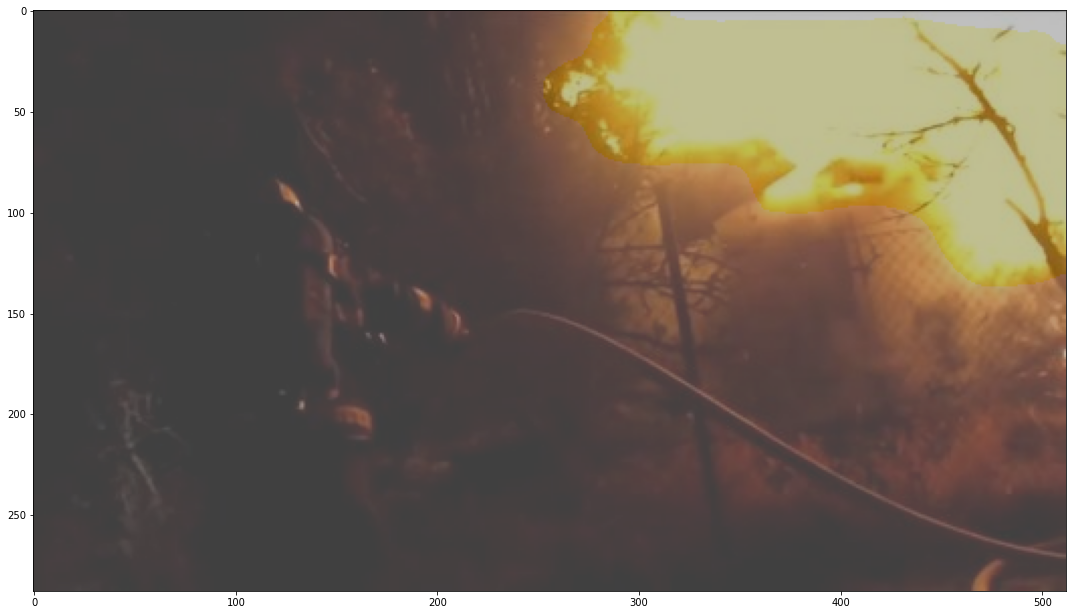

In [20]:
img = mmcv.imread('dataset_fire/dataset-fire-labelme-cropped-Images/2015-01-01_pozar_chaty__Brno-R-_gtzPSHZE_mkv/00003500.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

Analyze results

In [21]:
!python tools/analyze_logs.py '/content/drive/MyDrive/Colab Notebooks/NI-MVI/logs/None.log.json' --keys mIoU mAcc aAcc --legend mIoU mAcc aAcc --out metrics.png

plot curve of /content/drive/MyDrive/Colab Notebooks/NI-MVI/logs/None.log.json, metric is mIoU
plot curve of /content/drive/MyDrive/Colab Notebooks/NI-MVI/logs/None.log.json, metric is mAcc
plot curve of /content/drive/MyDrive/Colab Notebooks/NI-MVI/logs/None.log.json, metric is aAcc
save curve to: metrics.png


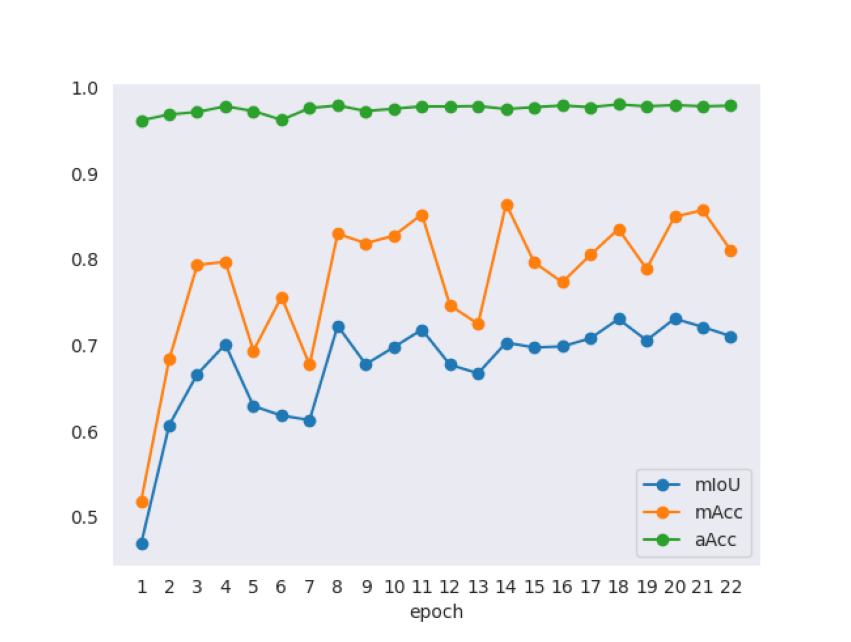

In [22]:
img = mmcv.imread('metrics.png')
plt.figure(figsize=(15, 20))
plt.imshow(mmcv.bgr2rgb(img))
plt.axis("off")
plt.show()

In [23]:
!python tools/analyze_logs.py '/content/drive/MyDrive/Colab Notebooks/NI-MVI/logs/None.log.json' --keys loss --legend loss --out loss.png

plot curve of /content/drive/MyDrive/Colab Notebooks/NI-MVI/logs/None.log.json, metric is loss
save curve to: loss.png


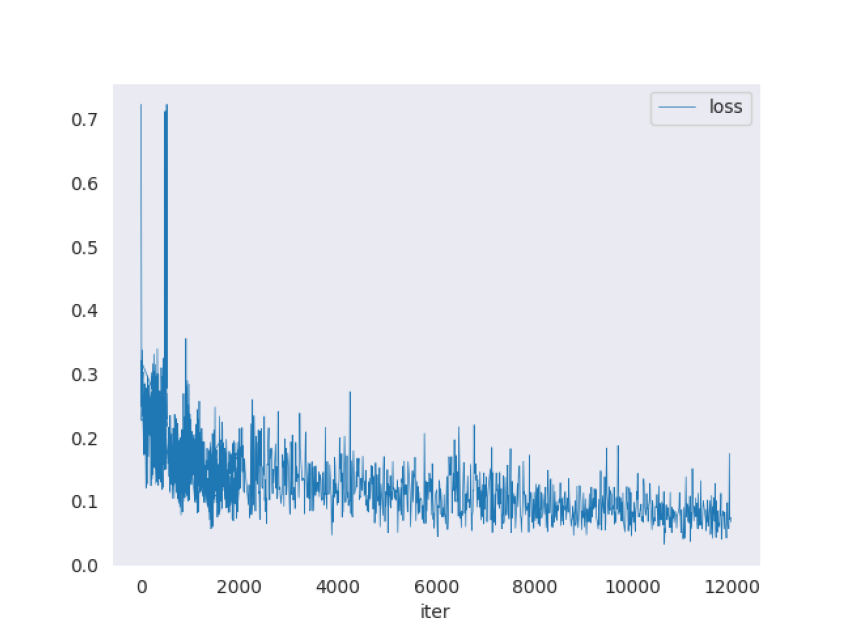

In [24]:
img = mmcv.imread('loss.png')
plt.figure(figsize=(15, 20))
plt.imshow(mmcv.bgr2rgb(img))
plt.axis("off")
plt.show()